# SMC samplers
SMC samplers are SMC algorithms that sample from a sequence of target distributions. In this tutorial, these target distributions will be Bayesian posterior distributions of static models. SMC samplers are covered in Chapter 17 of the book.

## Defining a static model

A static model is a Python object that represents a Bayesian model with static parameter $\theta$. One may define a static model by subclassing base class `StaticModel`, and defining method `logpyt`, which evaluates the log-likelihood of datapoint $Y_t$ (given $\theta$ and past datapoints $Y_{0:t-1}$). Here is a simple example: 

In [1]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')  # hide warnings 

from matplotlib import pyplot as plt
import seaborn as sb
from scipy import stats

import particles
from particles import smc_samplers as ssp
from particles import distributions as dists

class ToyModel(ssp.StaticModel):
    def logpyt(self, theta, t):  # density of Y_t given theta and Y_{0:t-1}
        return stats.norm.logpdf(self.data[t], loc=theta['mu'],
                                 scale = theta['sigma'])

In words, we are considering a model where the observations are $Y_t\sim N(\mu, \sigma^2)$. The parameter is $\theta=(\mu, \sigma)$.

Class `ToyModel` contains information about the likelihood of the considered model, but not about its prior, or the considered data. First, let's define those:

In [2]:
T = 1000
my_data = stats.norm.rvs(loc=3.14, size=T)  # simulated data
my_prior = dists.StructDist({'mu': dists.Normal(scale=10.),
                             'sigma': dists.Gamma()})

For more details about to define prior distributions, see the documentation of module `distributions`, or the previous [tutorial on Bayesian estimation of state-space models](Bayes_estimation_ssm.ipynb). Now that we have everything, let's specify our static model: 

In [3]:
my_static_model = ToyModel(data=my_data, prior=my_prior)

This time, object `my_static_model` has enough information to define the posterior distribution(s) of the model (given all data, or part of the data). In fact, it inherits from `StaticModel` method `logpost`, which evaluates (for a collection of $\theta$ values) the posterior log-density at any time $t$ (meaning given data $y_{0:t}$). 

In [4]:
thetas = my_prior.rvs(size=5) 
my_static_model.logpost(thetas, t=2)  # if t is omitted, gives the full posterior

array([ -103.81939366,    -8.74342665, -1574.47064329,   -33.24706434,
         -89.17306505])

The input of `logpost` (and output of `myprior.rvs()`) is a [structured array](https://docs.scipy.org/doc/numpy/user/basics.rec.html), with the same keys as the prior distribution:

In [5]:
thetas['mu'][0]

4.5636339239154635

Typically, you won't need to call `logpost` yourself, this will be done by the SMC sampler for you. 

## IBIS
The IBIS (iterated batch importance sampling) algorithm is a SMC sampler that samples iteratively from a sequence of posterior distributions, 
$p(\theta|y_{0:t})$, for $t=0,1,\ldots$. 

Module `smc_samplers` defines `IBIS` as a subclass of `FeynmanKac`. 

In [6]:
my_ibis = ssp.IBIS(my_static_model)
my_alg = particles.SMC(fk=my_ibis, N=1000, store_history=True)
my_alg.run()

Since we set `store_history` to `True`, the particles and their weights have been saved at every time (in attribute `hist`, see previous tutorials on smoothing). Let's plot the posterior distributions of $\mu$ and $\sigma$ at various times.

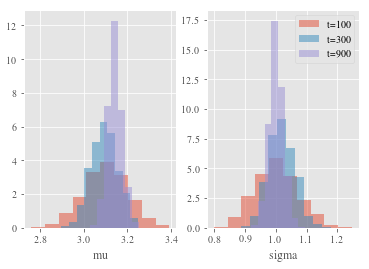

In [7]:
plt.style.use('ggplot')
for i, p in enumerate(['mu', 'sigma']):
    plt.subplot(1, 2, i + 1)
    for t in [100, 300, 900]:
        plt.hist(my_alg.hist.X[t].theta[p], weights=my_alg.hist.wgt[t].W, label="t=%i" % t, alpha=0.5, density=True)
    plt.xlabel(p)
plt.legend();

As expected, the posterior distribution concentrates progressively around the true values. 

As before, once the algorithm is run, `my_smc.X` contains the N final particles. However, object `my_smc.X` is no longer a simple (N,) or (N,d) numpy array. It is a `ThetaParticles` object, with attributes:

* theta: a structured array: as mentioned above, this is an array with fields; i.e. `my_smc.X.theta['mu']` is a (N,) array that contains the the $\mu-$component of the $N$ particles; 
* `lpost`: a (N,) numpy array that contains the target (posterior) log-density of each of the N particles;
* `acc_rates`: a list of the acceptance rates of the resample-move steps.

['23.33%', '12.70%', '26.07%', '31.82%', '32.75%', '31.90%', '35.50%', '35.98%', '33.75%', '35.28%']


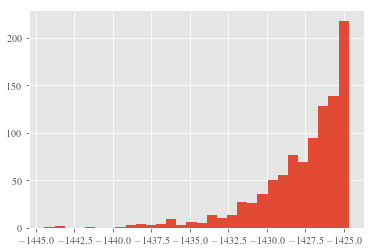

In [8]:
print(["%2.2f%%" % (100 * np.mean(r)) for r in my_alg.X.acc_rates])
plt.hist(my_alg.X.lpost, 30);

You do not need to know much more about class `ThetaParticles` for most practical purposes (see however the documention of module `smc_samplers` if you do want to know more, e.g. in order to implement other classes of SMC samplers).

## Regarding the Metropolis steps

As the text output of `my_alg.run()` suggests, the algorithm "resample-moves" whenever the ESS is below a certain threshold ($N/2$ by default). When this occurs, particles are resampled, and then moved through a certain number of Metropolis-Hastings steps. By default, the proposal is a Gaussian random walk, and both the number of steps and the covariance matrix of the random walk are chosen automatically as follows:
 
* the covariance matrix of the random walk is set to `scale` times   the empirical (weighted) covariance matrix of the particles. The default value for `scale` is $2.38 / \sqrt{d}$, where $d$ is the dimension of $\theta$. 
* the algorithm performs Metropolis steps until the relative increase of the  average distance between the starting point and the end point is below a certain threshold $\delta$. 

Class `IBIS` takes as an optional argument `mh_options`, a dictionary which may contain the following (key, values) pairs: 

* `'type_prop'`: either `'random walk'` or `'independent`'; in the latter case, an independent Gaussian proposal is used. The mean of the Gaussian is set to the weighted mean of the particles. The variance is set to `scale` times the weighted variance of the particles. 
* `'scale`': the scale of the proposal (as explained above). 
* `'nsteps'`: number of steps. If set to `0`, the adaptive strategy described above is used. 

Let's illustrate all this by calling IBIS again: 

In [9]:
alt_ibis = ssp.IBIS(my_static_model, mh_options={'type_prop': 'independent', 
                                                 'nsteps': 10})
alt_alg = particles.SMC(fk=alt_ibis, N=1000, ESSrmin=0.2)
alt_alg.run()

Well, apparently the algorithm did what we asked. We have also changed the threshold of 
 Let's see how the ESS evolved:

Text(0, 0.5, 'ESS')

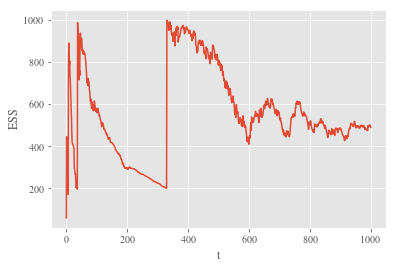

In [10]:
plt.plot(alt_alg.summaries.ESSs)
plt.xlabel('t')
plt.ylabel('ESS')

As expected, the algorithm waits until the ESS is below 200 to trigger a resample-move step.

## SMC tempering

SMC tempering is a SMC sampler that samples iteratively from the following sequence of distributions:

\begin{equation}
\pi_t(\theta) \propto \pi(\theta) L(\theta)^\gamma_t
\end{equation}

with $0=\gamma_0 < \ldots < \gamma_T = 1$. In words, this sequence is a **geometric bridge**, which interpolates between the prior and the posterior. 

SMC tempering implemented in the same was as IBIS: as a sub-class of `FeynmanKac`, whose `__init__` function takes as argument a `StaticModel` object. 

In [11]:
fk_tempering = ssp.AdaptiveTempering(my_static_model)
my_temp_alg = particles.SMC(fk=fk_tempering, N=1000, ESSrmin=1., verbose=True)
my_temp_alg.run()

t=0, ESS=500.00, tempering exponent=2.94e-05
t=1, Metropolis acc. rate (over 6 steps): 0.275, ESS=500.00, tempering exponent=0.000325
t=2, Metropolis acc. rate (over 6 steps): 0.261, ESS=500.00, tempering exponent=0.0018
t=3, Metropolis acc. rate (over 6 steps): 0.253, ESS=500.00, tempering exponent=0.0061
t=4, Metropolis acc. rate (over 6 steps): 0.287, ESS=500.00, tempering exponent=0.0193
t=5, Metropolis acc. rate (over 6 steps): 0.338, ESS=500.00, tempering exponent=0.0636
t=6, Metropolis acc. rate (over 6 steps): 0.347, ESS=500.00, tempering exponent=0.218
t=7, Metropolis acc. rate (over 5 steps): 0.358, ESS=500.00, tempering exponent=0.765
t=8, Metropolis acc. rate (over 5 steps): 0.366, ESS=941.43, tempering exponent=1


**Note**: Recall that `SMC` resamples every time the ESS drops below value N times option `ESSrmin`; here we set it to to 1, since we want to resample at every time. This makes sense: Adaptive SMC chooses adaptively the successive values of $\gamma_t$ so that the ESS drops to $N/2$ (by default). 

**Note**: we use option `verbose=True` in `SMC` in order to print some information on the intermediate distributions. 

We have not saved the intermediate results this time (option `store_history` was not set) since they are not particularly interesting. Let's look at the final results: 

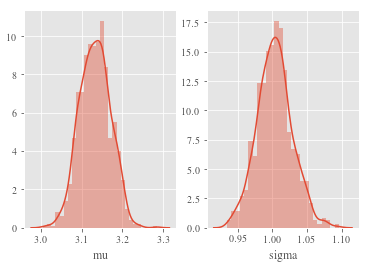

In [12]:
for i, p in enumerate(['mu', 'sigma']):
    plt.subplot(1, 2, i + 1)
    sb.distplot(my_temp_alg.X.theta[p])
    plt.xlabel(p)

This looks reasonable!
You can see from the output that the algorithm automatically chooses the tempering exponents $\gamma_1, \gamma_2,\ldots$. In fact, at iteration $t$, the next value for $\gamma$ is set that the ESS drops at most to $N/2$. You can change this particular threshold by passing argument ESSrmin to TemperingSMC. (Warning: do not mistake this with the `ESSrmin` argument of class `SMC`):

In [13]:
lazy_tempering = ssp.AdaptiveTempering(my_static_model, ESSrmin = 0.1)
lazy_alg = particles.SMC(fk=lazy_tempering, N=1000, verbose=True)
lazy_alg.run()

t=0, ESS=100.00, tempering exponent=0.00097
t=1, Metropolis acc. rate (over 5 steps): 0.233, ESS=100.00, tempering exponent=0.0217
t=2, Metropolis acc. rate (over 6 steps): 0.323, ESS=100.00, tempering exponent=0.315
t=3, Metropolis acc. rate (over 5 steps): 0.338, ESS=520.51, tempering exponent=1


The algorithm progresses faster this time, but the ESS drops more between each step.
Another optional argument for Class `TemperingSMC` is `options_mh`, which works exactly as for `IBIS`, see above. That is, by default, the particles are moved according to a certain (adaptative) number of random walk steps, with a variance calibrated to the particle variance.